# 1  Task Definition


* Derive model for household energy consumption (natural gas or fuel oil) for space and water heating based on temperature measurements
* Temperature data from closest automated weather station; hourly measurements
* Gas consumption is recorded manually from gas meter

* Focus on explainability: The final model should be easy to interpret

# 2  Package Import

According to the Python style guide (https://www.python.org/dev/peps/pep-0008), we place all imports at the top of the file

In [1]:
# standard library
from datetime import datetime
import xml.etree.ElementTree as ET

# Python Scientific Stack
import numpy as np
import pandas as pd
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

# Tensorflow / Keras
from tensorflow import keras

# 3  Data Aquisition

## 3.0 Helper Functions

In [2]:
def read_csv_data(filename, col_dict, sep):
    """
    Arguments:
        filename: csv input file
        col_dict: dict of columns to read from csv files
                  keys: column id
                  values: column name
        sep: csv file column separator
        
    Returns:
        df: pandas DataFrame containing 2 columns: datetime, temperature
    """

    df = pd.read_csv(filename, sep=sep, header=0, names=col_dict.values(), usecols=col_dict.keys())
    df.dropna(axis=0, inplace=True)
        
    return df

def create_date_time_col(df, names, fstring):
    """
    Convert column with date string to datetime column
    
    Arguments:
        df: dataframe
        names[0]: name of date column
        names[1]: name for datetime column
        fstring: format string for dates
    """

    # create datetime column and remove original date column
    df.insert(0, names[1], pd.to_datetime(df.rawdate, format=fstring))
    del df[names[0]]


def join_by_datetime(df_list, startdate):
    """
    Create new dataframe by joining a list of dataframes in the given order
    
    Arguments:
        df_list: list of dataframes; must be sorted
        startdate: all dates in first dataframe prior to this date are ignored
    """
    
    # drop values before startdate from first dataframe
    startdate = datetime.fromisoformat(startdate)
    rows = temp_hist[df_list[0].datetime >= startdate].index
    df = df_list[0].loc[rows]

    for i in df_list[1:]:
        enddate = df.datetime.iloc[-1]
        rows = i[i.datetime > enddate].index
        df = df.append(i.loc[rows], ignore_index=True)
        
    return df

## 3.1 Temperature Data

* Temperature data is obtained from <b>DWD Open Data Server</b>: https://opendata.dwd.de/
* The nearest automated weather station is chosen
* We read the data into a Pandas DataFrame and convert the time signature into a datetime object
* As the data is contained in two files with overlapping timestamps, we join the data from both files into a single dataframe, dropping overlapping timestamps from the second file (we assume the data in the first file has been verified)
* Finally, we drop timestamps were the recorded temperatures are clearly erroneous, i.e. we drop temperatures below -50°C.

In [3]:
temp_file_hist = 'produkt_tu_stunde_20020124_20191231_04411.txt'
temp_file_recent = 'produkt_tu_stunde_20190212_20200814_04411.txt'

sep = ';'
fstring = '%Y%m%d%H'
col_dict_temp = {1: 'rawdate',
                 3: 'temperature',
                }
startdate = '2012-01-01T00:00:00'

# "historical" temperatures
temp_hist = read_csv_data(temp_file_hist, col_dict_temp, sep)
create_date_time_col(temp_hist, ['rawdate', 'datetime'], fstring)

# recent temperatures
temp_recent = read_csv_data(temp_file_recent, col_dict_temp, sep)
create_date_time_col(temp_recent, ['rawdate', 'datetime'], fstring)

# create temperature dataframe
temp = join_by_datetime([temp_hist, temp_recent], startdate)

# drop wrong values (limit set to -50°C)
rows = temp[temp.temperature < -50.0].index
temp.drop(labels=rows, axis=0, inplace=True)

print('Sanity Check for Temperature Dataframe:')
print('Duplicate dates:', temp.duplicated(subset=['datetime']).sum())
print('Monotonically increasing dates:', temp['datetime'].is_monotonic_increasing)

print(temp.datetime.diff().describe())
print(temp.head())
print(temp.tail())

Sanity Check for Temperature Dataframe:
Duplicate dates: 0
Monotonically increasing dates: True
count                     75372
mean     0 days 01:00:09.695908
std      0 days 00:44:08.830348
min             0 days 01:00:00
25%             0 days 01:00:00
50%             0 days 01:00:00
75%             0 days 01:00:00
max             8 days 11:00:00
Name: datetime, dtype: object
             datetime  temperature
0 2012-01-01 00:00:00         10.1
1 2012-01-01 01:00:00         10.6
2 2012-01-01 02:00:00         10.7
3 2012-01-01 03:00:00         11.0
4 2012-01-01 04:00:00         10.5
                 datetime  temperature
75374 2020-08-14 19:00:00         19.8
75375 2020-08-14 20:00:00         19.3
75376 2020-08-14 21:00:00         18.5
75377 2020-08-14 22:00:00         18.6
75378 2020-08-14 23:00:00         18.8


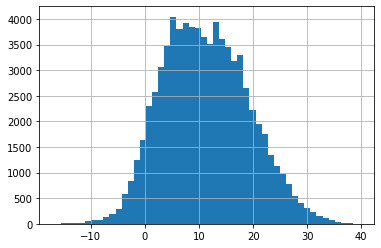

In [4]:
# check if temperature data is approximately normally distributed
temp['temperature'].hist(bins=50)

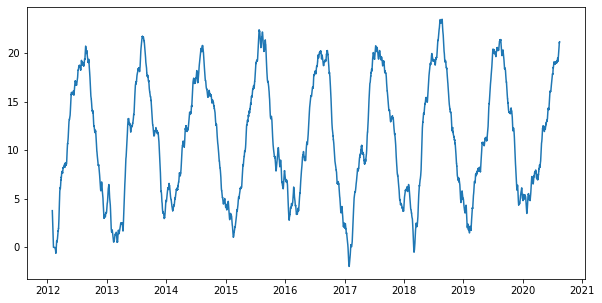

In [5]:
# check for trend in temperature time series data using sliding mean
rm = temp.rolling(window=720, on='datetime').mean()
plt.figure(figsize=(10, 5))
plt.plot(rm.datetime, rm.temperature)
#plt.xlabel('daily mean temperature [°C]')
#plt.ylabel('daily gas consumption [kWh]')

* Hourly measurements
* Temperature is measured in degree Celsius
* Temperature data is approximaltey normally distributed
* No strong trend in rolling mean time history data

## 3.2 Natural Gas Consumption Data

* gas meter data [kWh]
* stored in csv file

In [6]:
gas_file = 'consumption.csv'
col_dict_gas =  {0: 'rawdate',
                 1: 'cummulated',
                }
gas = read_csv_data(gas_file, col_dict_gas, ',')
create_date_time_col(gas, ['rawdate', 'datetime'], '%d.%m.%y')

rows = gas[gas.datetime < startdate].index
gas.drop(labels=rows, axis=0, inplace=True)

print('Sanity Check for Gas Consumption Dataframe:')
print('Duplicate dates:', gas.duplicated(subset=['datetime']).sum())
print('Monotonically increasing dates:', gas['datetime'].is_monotonic_increasing)

print(gas.datetime.diff().describe())
print(gas.head())
print(gas.tail())

Sanity Check for Gas Consumption Dataframe:
Duplicate dates: 0
Monotonically increasing dates: True
count                       443
mean     7 days 03:02:01.896162
std      1 days 16:55:12.913928
min             1 days 00:00:00
25%             7 days 00:00:00
50%             7 days 00:00:00
75%             7 days 00:00:00
max            28 days 00:00:00
Name: datetime, dtype: object
    datetime  cummulated
4 2012-01-01     15558.0
5 2012-01-07     15633.0
6 2012-01-14     15708.0
7 2012-01-21     15805.0
8 2012-01-28     15893.0
      datetime  cummulated
463 2020-07-19     36821.0
464 2020-07-26     36843.0
465 2020-08-02     36863.0
467 2020-08-16     36897.0
468 2020-08-23     36917.0


* varying length of time intervals

# 4  Data Preparation

The next step is to join the data from 2 different sources into a signle dataframe.

Approach:
* use time intervals between two gas consumption measurements as samples
* compute total gas consumption and mean daily gas consumption for each interval
* compute mean interval temperature on each interval

## 4.1 Feature Conversion

As the data comes from 2 sources with different timesteps, convert the data to fit it into a single dataframe.

In [7]:
df = gas.copy()

# create increment column
df['increment'] = df['cummulated'].diff()
# create length of interval column
df['length'] = df['datetime'].diff()
# daily increment
df['daily_incr'] = df['increment'] / df['length'].dt.days
# month of year
#gas['month_of_year'] = gas['datetime'].dt.month

# TODO there must be a better way to do this
l = [0.0]
for i in range(1, len(df.index)):
    start = df['datetime'].iloc[i-1]
    end = df['datetime'].iloc[i]
    rows = (temp['datetime'] >= start) & (temp['datetime'] < end)
    mean = temp.loc[rows, 'temperature'].mean()
    l.append(mean)

df['mean_temp'] = l

In [8]:
print(df.head())
#print(df.tail())
print(df.info())

    datetime  cummulated  increment length  daily_incr  mean_temp
4 2012-01-01     15558.0        NaN    NaT         NaN   0.000000
5 2012-01-07     15633.0       75.0 6 days   12.500000   7.902778
6 2012-01-14     15708.0       75.0 7 days   10.714286   5.868452
7 2012-01-21     15805.0       97.0 7 days   13.857143   0.511905
8 2012-01-28     15893.0       88.0 7 days   12.571429   2.874405
<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 4 to 468
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   datetime    444 non-null    datetime64[ns] 
 1   cummulated  444 non-null    float64        
 2   increment   443 non-null    float64        
 3   length      443 non-null    timedelta64[ns]
 4   daily_incr  443 non-null    float64        
 5   mean_temp   443 non-null    float64        
dtypes: datetime64[ns](1), float64(4), timedelta64[ns](1)
memory usage: 24.3 KB
None


Text(0, 0.5, 'daily gas consumption [kWh]')

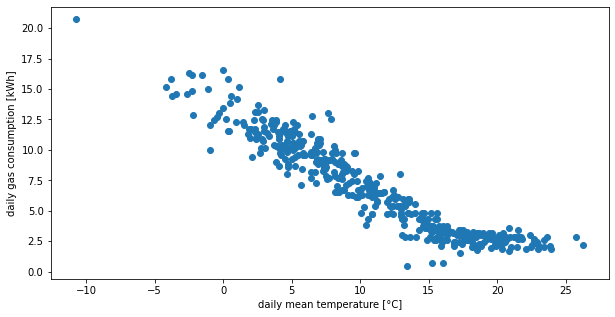

In [9]:
plt.figure(figsize=(10, 5))
plt.scatter(df.mean_temp, df.daily_incr)
plt.xlabel('daily mean temperature [°C]')
plt.ylabel('daily gas consumption [kWh]')

* Kink at ~15°C:
  - space heating switched off at certain outside temperature threshold
  - only water heating for higher outside temperatures

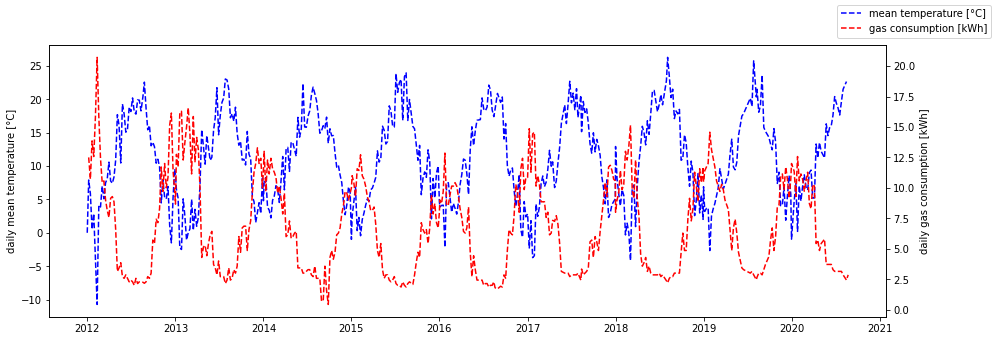

In [10]:
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(df.datetime, df.mean_temp, 'b--', label='mean temperature [°C]')
ax1.set_ylabel('daily mean temperature [°C]')
ax2 = ax1.twinx()         
ax2.plot(df.datetime, df.daily_incr, 'r--', label='gas consumption [kWh]')
ax2.set_ylabel('daily gas consumption [kWh]')
fig.legend()

## 4.2 Train/Test Set Split

Due to the small amount of data, we are using a stratified split for setting aside the test set.
This ensures that the temperature distribution in both the training set and the test set equals the distribution of the full dataset.

Index(['datetime', 'cummulated', 'increment', 'length', 'daily_incr',
       'mean_temp'],
      dtype='object')
      datetime  cummulated  increment length  daily_incr  mean_temp temp_cat
305 2017-08-27     29394.0       21.0 7 days    3.000000  18.026190        5
379 2018-12-30     32751.0       82.0 7 days   11.714286   2.007143        2
94  2013-09-14     20269.0       25.0 7 days    3.571429  14.882738        4
138 2014-07-12     22636.0       23.0 7 days    3.285714  18.246429        5
401 2019-05-26     34146.0       33.0 7 days    4.714286  14.530952        4
..         ...         ...        ...    ...         ...        ...      ...
463 2020-07-19     36821.0       22.0 7 days    3.142857  17.639286        5
416 2019-09-01     34440.0       20.0 7 days    2.857143  23.616667        6
243 2016-07-03     26865.0       14.0 7 days    2.000000  18.535928        5
11  2012-02-18     16260.0      111.0 7 days   15.857143   4.142373        2
396 2019-04-21     33936.0       46.0 7 

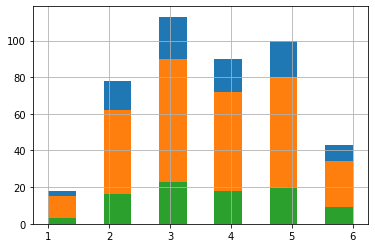

In [11]:
print(df.columns)
df.dropna(axis=0, inplace=True)

df['temp_cat'] = pd.cut(df['mean_temp'], 
                        bins=[-np.inf, 0.0, 5.0, 10.0, 15.0, 20.0, np.inf],
                        labels=[1, 2, 3, 4, 5, 6])
df['temp_cat'].hist(bins=11)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['temp_cat']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]
    
strat_train_set['temp_cat'].hist(bins=11)
strat_test_set['temp_cat'].hist(bins=11)

print(strat_train_set)

# 4a Data Exploration

In [12]:
print(strat_train_set.corr())

            cummulated  increment  daily_incr  mean_temp
cummulated    1.000000  -0.035197   -0.082128   0.087357
increment    -0.035197   1.000000    0.950127  -0.900409
daily_incr   -0.082128   0.950127    1.000000  -0.943538
mean_temp     0.087357  -0.900409   -0.943538   1.000000


1) We see a strong negative correlation between the daily gas consumption and the mean temperature. This will be the basis of the models we are investigating in the next section.

2) There is also a strong positive correlation between the total increment and the daily increment, which makes sense since the daily increment has been computed from the total increment by normalization.

3) Finally, there is also a strong negative correlation betwenn the total increment and the mean temperature. However, due to 2), we prefer to use the daily increment as the only regressor variable.

Text(0, 0.5, 'daily gas consumption [kWh]')

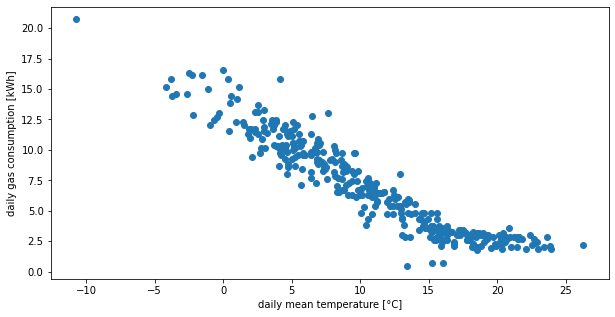

In [13]:
plt.figure(figsize=(10, 5))
plt.scatter(strat_train_set.mean_temp, strat_train_set.daily_incr)
plt.xlabel('daily mean temperature [°C]')
plt.ylabel('daily gas consumption [kWh]')

# 5 Model Buildup

* Samples are given by the time intervals between gas consumption measurements
* Use mean interval temperature as independent variable
* Use mean daily gas consumption as dependent variable

all models are trained using cross validation

In [14]:
xd = np.linspace(-20, 30, 500)
nsplits = 5

X = strat_train_set['mean_temp'].values.reshape(-1,1)
y = strat_train_set['daily_incr'].values.reshape(-1,1)

## 5.0 Helper Functions

In [15]:
def kfold_cross_val(X, y, model_generator, n_splits, fit_params={}):

    ss = KFold(n_splits=n_splits)
    mse_list = []
    
    for train_index, test_index in ss.split(X, y):
        #print("%s %s" % (len(train_index), len(test_index)))
        model = model_generator
        X_train_fold = X[train_index]
        X_test_fold = X[test_index]
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]
        
        model.fit(X_train_fold, y_train_fold, **fit_params)
        y_pred_fold = model.predict(X_test_fold)
        mse = mean_squared_error(y_test_fold, y_pred_fold)
        mse_list.append(mse)    
    
    return mse_list

## 5.1 Baseline Model: Linear Regression

In [16]:
# Model 1: Linear Regression
print('\nModel 1: Linear Regression')

mse_cv1 = kfold_cross_val(X, y, LinearRegression(), n_splits=nsplits)

print('Cross Validation MSE:', mse_cv1, '\n', sum(mse_cv1)/nsplits)
#print('Cross Validation RMSE:', np.sqrt(mse_cv1), sum(np.sqrt(mse_cv1))/nsplits)

# train model on full training data
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print("\nLinear Model Results")
print(lin_reg.coef_)
print(lin_reg.intercept_)
mse1 = mean_squared_error(y, lin_reg.predict(X))
print("Model 1 MSE: ", mse1)
#print("Model 1 RMSE: ", np.sqrt(mse1))


Model 1: Linear Regression
Cross Validation MSE: [1.123608673082506, 2.044868212658899, 1.131994798944838, 2.0235297270991413, 2.2257269657709227] 
 1.7099456755112612

Linear Model Results
[[-0.55426065]]
[12.9802372]
Model 1 MSE:  1.6943426999603868


In [17]:
# TEST compare results of kfold_cross_val function to sklearn builtin cross_val_score
lin_reg_cv = LinearRegression()

lin_scores= cross_val_score(lin_reg_cv, X, y, scoring="neg_mean_squared_error", cv=nsplits)
print(-lin_scores)
print(sum(-lin_scores)/nsplits)

[1.12360867 2.04486821 1.1319948  2.02352973 2.22572697]
1.7099456755112612


Text(0, 0.5, 'daily gas consumption [kWh]')

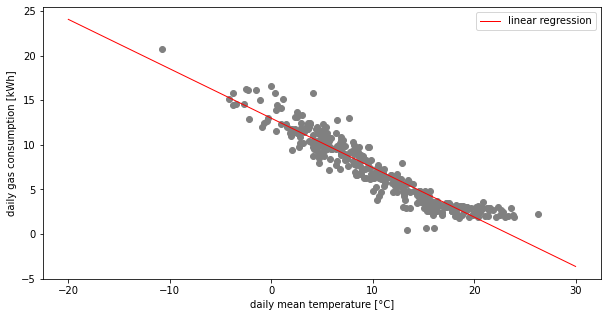

In [18]:
y_pred = lin_reg.predict(xd.reshape(-1,1))

plt.figure(figsize=(10, 5))
plt.scatter(X, y,  color='gray')
plt.plot(xd, y_pred, color='red', linewidth=1, label="linear regression")
plt.legend()
plt.xlabel('daily mean temperature [°C]')
plt.ylabel('daily gas consumption [kWh]')

Text(0, 0.5, 'residuals [kWh]')

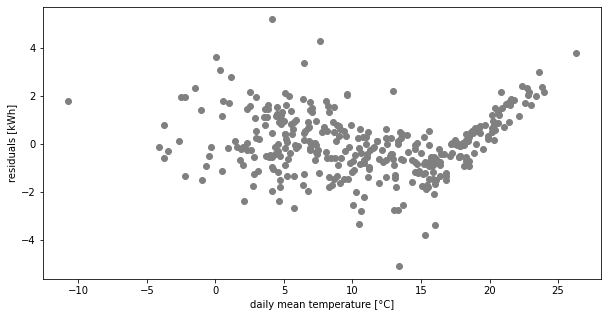

In [19]:
plt.figure(figsize=(10, 5))
plt.scatter(X, y-lin_reg.predict(X),  color='gray')
plt.xlabel('daily mean temperature [°C]')
plt.ylabel('residuals [kWh]')

* Overall good approximation to training data
* Kink at ~15°C in data not captured due to linearity of the model
* High bias: underfitting
* Trend in residuals for temperatures above ~15°C.

# 5.2 Model 2: Neural Network

In [20]:
# Model 2: Neural Network
print('\nModel 2: Neural Network')

def get_nn():
    model2 = keras.models.Sequential([
        keras.layers.Dense(4,
                        activation="relu",
                        input_shape=X.shape[1:],
                        kernel_regularizer=keras.regularizers.l2(0.001),
                        ),
        keras.layers.Dense(10,
                        activation="relu",
                        kernel_regularizer=keras.regularizers.l2(0.001),
                        ),
        keras.layers.Dense(1)
        ])

    model2.compile(loss="mean_squared_error", optimizer="adam")
    
    return model2


Model 2: Neural Network


In [21]:
mse_cv2 = kfold_cross_val(X, y, get_nn(), n_splits=nsplits, fit_params={'epochs': 500, 'verbose':0})

print('Cross Validation MSE:', mse_cv2, '\n', sum(mse_cv2)/nsplits)

model2 = get_nn()
history = model2.fit(X, y, epochs=500, verbose=0)

mse2 = mean_squared_error(y, model2.predict(X))
print("Model 2 MSE: ", mse2)

Cross Validation MSE: [1.3798092746229318, 1.5450590392697818, 0.7728171541812241, 1.4069139788213603, 1.4603929768866302] 
 1.3129984847563856
Model 2 MSE:  1.1648276605434267


Text(0, 0.5, 'daily gas consumption [kWh]')

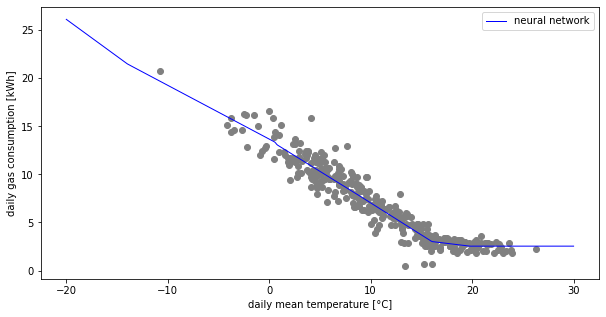

In [22]:
y_pred2 = model2.predict(xd)

plt.figure(figsize=(10, 5))
plt.scatter(X, y,  color='gray')
plt.plot(xd, y_pred2, color='blue', linewidth=1, label="neural network")
plt.legend()
plt.xlabel('daily mean temperature [°C]')
plt.ylabel('daily gas consumption [kWh]')

Text(0, 0.5, 'residuals [kWh]')

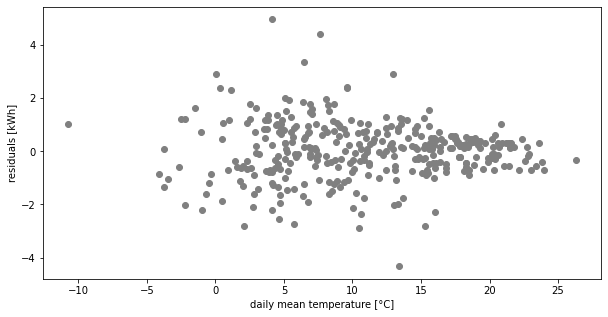

In [23]:
plt.figure(figsize=(10, 5))
plt.scatter(X, y - model2.predict(X),  color='gray')
plt.xlabel('daily mean temperature [°C]')
plt.ylabel('residuals [kWh]')

* Very good approximation to training data (prone to overfitting)
* Kink at ~15°C in data captured
* No trend in residuals
* Limited explainability: black-box model

## 5.3 Model 3: Polynomial Regression

In [24]:
print('\nModel 3: Polynomial Regression')
poly_features = PolynomialFeatures(degree=8, include_bias=False)
X_poly = poly_features.fit_transform(X)

mse_cv3 = kfold_cross_val(X_poly, y, ElasticNet(alpha=0.1, l1_ratio=0.5), n_splits=nsplits)
print('Cross Validation MSE:', mse_cv3, '\n', sum(mse_cv3)/nsplits)

lin_reg3 = ElasticNet(alpha=0.1, l1_ratio=0.5)
lin_reg3.fit(X_poly, y)
print("\nPolynomial Model Results")
print(lin_reg3.coef_)
print(lin_reg3.intercept_)
#y_pred3 = lin_reg3.predict(X_poly)
mse3 = mean_squared_error(y, lin_reg3.predict(X_poly))
print("Model 3 MSE: ", mse3)


Model 3: Polynomial Regression
Cross Validation MSE: [1.3527480491284358, 1.5258804487106676, 0.8458541135042271, 1.3871176569138715, 1.455941936480722] 
 1.3135084409475848

Polynomial Model Results
[-4.95449427e-01 -1.06638856e-02 -1.09995155e-03  7.19354980e-05
  3.24927440e-07  3.21282659e-08 -9.29715309e-10 -5.35705908e-11]
[13.38550833]
Model 3 MSE:  1.1713786492176679


/home/brandy/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.17084047251896, tolerance: 0.4405273144854353
  model = cd_fast.enet_coordinate_descent(
/home/brandy/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162.4166944580202, tolerance: 0.4291614985527973
  model = cd_fast.enet_coordinate_descent(
/home/brandy/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185.46113427670528, tolerance: 0.4439432218164571
  model = cd_fast.enet_coordinate_descent(
/home/brandy/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.

In [25]:
poly_reg = ElasticNet(alpha=0.1, l1_ratio=0.5)

poly_scores= cross_val_score(poly_reg, X_poly, y, scoring="neg_mean_squared_error", cv=5)
print(-poly_scores)
print(sum(-poly_scores)/5.0)

[1.35274805 1.52588045 0.84585411 1.38711766 1.45594194]
1.3135084409475848


/home/brandy/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.17084047251896, tolerance: 0.4405273144854353
  model = cd_fast.enet_coordinate_descent(
/home/brandy/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162.4166944580202, tolerance: 0.4291614985527973
  model = cd_fast.enet_coordinate_descent(
/home/brandy/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185.46113427670528, tolerance: 0.4439432218164571
  model = cd_fast.enet_coordinate_descent(
/home/brandy/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.

Text(0, 0.5, 'daily gas consumption [kWh]')

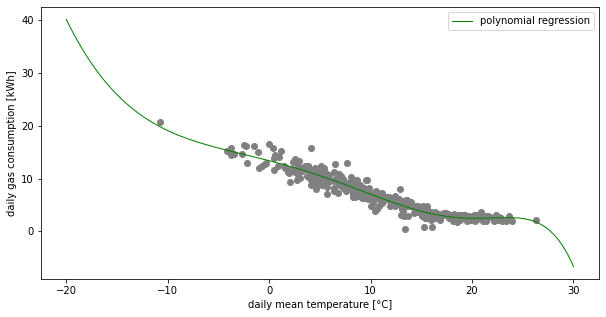

In [26]:
y_pred3 = lin_reg3.predict(poly_features.transform(xd.reshape(-1,1)))

plt.figure(figsize=(10, 5))
plt.scatter(X, y,  color='gray')
plt.plot(xd, y_pred3, color='green', linewidth=1, label='polynomial regression')
plt.legend()
plt.xlabel('daily mean temperature [°C]')
plt.ylabel('daily gas consumption [kWh]')

Text(0, 0.5, 'residuals [kWh]')

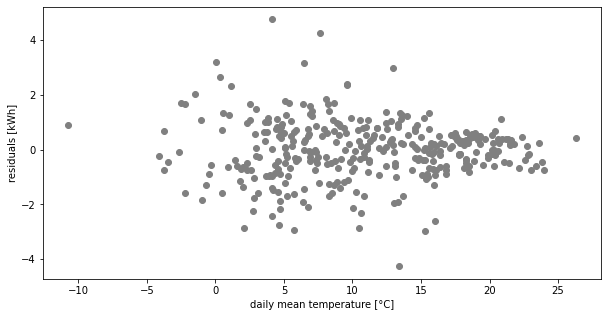

In [27]:
plt.figure(figsize=(10, 5))
plt.scatter(X, y - lin_reg3.predict(X_poly).reshape(-1,1),  color='gray')
plt.xlabel('daily mean temperature [°C]')
plt.ylabel('residuals [kWh]')

Observations:
* Very good approximation to training data
* Kink at ~15°C in data captured
* Degradation of model quality for low or high temperatures: weak extrapolation quality
* Cross Validation MSE is higher than MSE for full training data: model is prone to overfitting

## 5.4 Model 4: Piecewise Linear Regression (Segmented Regression)

Due to the structure of the data and the background knowledge that space heating is switched of above a certain measured outside temperature, the next model we test is a <b>piecewise linear regression</b>, also called <b>segmented regression</b> (https://en.wikipedia.org/wiki/Segmented_regression).

In [28]:
# Model 4: piecewise linear function
# https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python
# NOTE important to set initial values for optimization
# NOTE otherwise, optimizer does not converge in cross-validation for some folds due to small dataset
print('\nModel 4: Piecewise Linear Regression')
def piecewise_linear(x, xbar, ybar, a1, a2):
    return np.piecewise(x, [x < xbar, x >= xbar], [lambda x: a1*x + ybar - a1*xbar, lambda x: a2*x + ybar - a2*xbar])


#ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
ss = KFold(n_splits=5)
mse_cv4 = []
for train_index, test_index in ss.split(X, y):

    X_train_fold = X[train_index]
    X_test_fold = X[test_index]
    y_train_fold = y[train_index]
    y_test_fold = y[test_index]
    
    p, e = optimize.curve_fit(piecewise_linear, X_train_fold.flatten(), y_train_fold.flatten(), p0=[20.0, 3.0, 0.0, 0.0])
    
    y_pred_clone = piecewise_linear(X_test_fold, *p)
    mse = mean_squared_error(y_test_fold, y_pred_clone)
    mse_cv4.append(mse)


print('Cross Validation MSE:', mse_cv4, '\n', sum(mse_cv4)/5.0)

p, e = optimize.curve_fit(piecewise_linear, X.flatten(), y.flatten(), p0=[20.0, 3.0, 0.0, 0.0])
print('Piecewise Linear Regression Parameters: ', p)

mse4 = mean_squared_error(y, piecewise_linear(X, *p))
print("Model 4 MSE: ", mse4)


Model 4: Piecewise Linear Regression
Cross Validation MSE: [0.7696734956751317, 1.55808561025727, 0.8070537769224402, 1.3887600265077977, 1.3945091631525381] 
 1.1836164145030357
Piecewise Linear Regression Parameters:  [16.20133352  2.9835503  -0.65763927 -0.09120623]
Model 4 MSE:  1.171578348491093


Text(0, 0.5, 'daily gas consumption [kWh]')

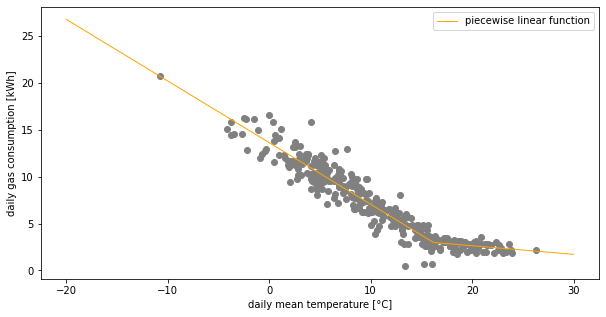

In [29]:
y_pred4 = piecewise_linear(xd, *p)

plt.figure(figsize=(10, 5))
plt.scatter(X, y,  color='gray')
plt.plot(xd, y_pred4, color='orange', linewidth=1, label="piecewise linear function")
plt.legend()
plt.xlabel('daily mean temperature [°C]')
plt.ylabel('daily gas consumption [kWh]')

Text(0, 0.5, 'residuals [kWh]')

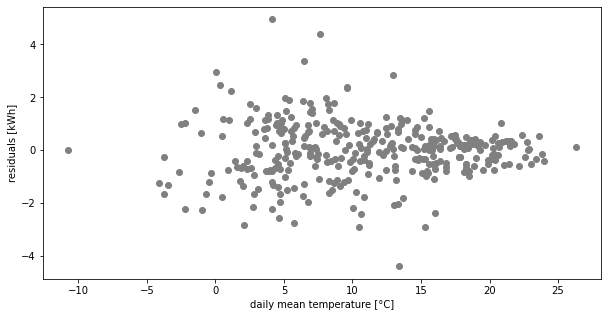

In [30]:
plt.figure(figsize=(10, 5))
plt.scatter(X, y - piecewise_linear(X, *p),  color='gray')
plt.xlabel('daily mean temperature [°C]')
plt.ylabel('residuals [kWh]')

* Very good approximation to training data
* Kink at ~15°C in data captured: (xbar, ybar) ~ (16.6, 2.8)
* No trend in residuals
* Very good explainability

## 5.5 Model Evaluation and Final Model Selection

Text(0, 0.5, 'daily gas consumption [kWh]')

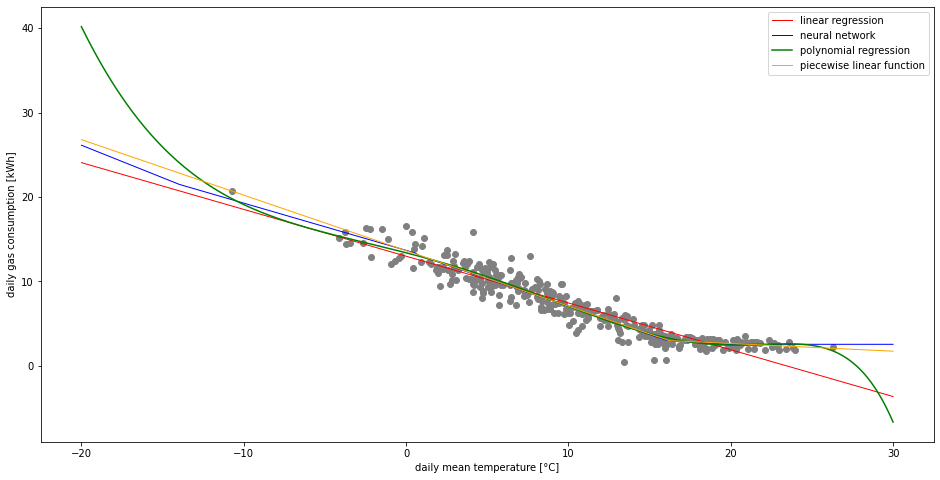

In [31]:
plt.figure(figsize=(16, 8))
plt.scatter(X, y,  color='gray')
plt.plot(xd, y_pred, color='red', linewidth=1, label="linear regression")
plt.plot(xd, y_pred2, color='blue', linewidth=1, label="neural network")
plt.plot(xd, y_pred3, color='green', label='polynomial regression')
plt.plot(xd, y_pred4, color='orange', linewidth=1, label="piecewise linear function")
plt.legend()
plt.xlabel('daily mean temperature [°C]')
plt.ylabel('daily gas consumption [kWh]')

# 6 Choice of Final Model and Evaluation on Test Data

The neural network (model 2) and the piecewise linear regression (model 4) show the smallest cross validation mean squared error. Also, the mse on the full training data is comparable. Due to the better explainability and the smaller risk for overfitting the training data, we choose the piecewise linear regression (model 4) as the final model.

## 6.1 Evaluation on test data

<b>Important Note:</b> We are computing the MSE on the test set here on all models for purely academic reasons.
We are not allowed to change our choice for the final model based on these results because this would introduce leakage from the test set into the model.

The MSE for model 4 yields an estimator for the generalization error.

In [32]:
X_test = strat_test_set['mean_temp'].values.reshape(-1,1)
y_test = strat_test_set['daily_incr'].values.reshape(-1,1)

y_test_pred1 = lin_reg.predict(X_test)
mse_test1 = mean_squared_error(y_test, y_test_pred1)
print("\nTEST SET ERROR model 1: ", mse_test1)

y_test_pred2 = model2.predict(X_test)
mse_test2 = mean_squared_error(y_test, y_test_pred2)
print("\nTEST SET ERROR model 2: ", mse_test2)

X_test_poly = poly_features.transform(X_test)
y_test_pred3 = lin_reg3.predict(X_test_poly)
mse_test3 = mean_squared_error(y_test, y_test_pred3)
print("\nTEST SET ERROR model 3: ", mse_test3)

y_test_pred4 = piecewise_linear(X_test, *p)
mse_test4 = mean_squared_error(y_test, y_test_pred4)
print("\nTEST SET ERROR model 4: ", mse_test4)


TEST SET ERROR model 1:  1.594799800906994

TEST SET ERROR model 2:  1.0559950418674944

TEST SET ERROR model 3:  1.0090963114026765

TEST SET ERROR model 4:  1.0632828612737912


# 7 Prediction of Future Gas Consumption

## 7.1 Short Term Weather Prognosis

* Temperature prediction data is again obtained from DWD Open Data Server: https://opendata.dwd.de/
* Even if there is a nearer forecast point, the same weather station as for the training is used so that we don't introduce a bias

In [33]:
# make predictions
predict_file = 'MOSMIX_L_2020082609_L894.kml'

tree = ET.parse(predict_file)
root = tree.getroot()

# timesteps
sub1 = root[0][0][0][5]
timesteps = []
for child in sub1:
    timesteps.append(child.text)

# temperatures
sub2 = root[0][1][2][3]
temperatures = sub2[0].text.split()

prog_data = pd.DataFrame(data={'rawdate': timesteps, 'temperatures': temperatures})
prog_data['temperatures'] = prog_data['temperatures'].astype(float) - 273.15
fstring = '%Y-%m-%dT%H:%M:%S.000Z'
prog_data.insert(0, 'datetime', pd.to_datetime(prog_data.rawdate, format=fstring))
del prog_data['rawdate']


prog_data_daily = prog_data.resample('D', on='datetime').mean()
X = prog_data_daily['temperatures'].to_numpy()

def piecewise_linear(x, xbar, ybar, a1, a2):
    return np.piecewise(x, [x < xbar, x >= xbar], [lambda x: a1*x + ybar - a1*xbar, lambda x: a2*x + ybar - a2*xbar])

p = [16.58814381, 2.77447928, -0.64881576, -0.05466255]
pred = piecewise_linear(X, *p)

prog_data_daily['consumption'] = pred
print(prog_data_daily)

            temperatures  consumption
datetime                             
2020-08-26     20.164286     2.578998
2020-08-27     17.475000     2.726001
2020-08-28     17.687500     2.714386
2020-08-29     16.458333     2.858702
2020-08-30     15.283333     3.621061
2020-08-31     14.729167     3.980613
2020-09-01     14.475000     4.145520
2020-09-02     14.370833     4.213105
2020-09-03     14.729167     3.980613
2020-09-04     15.433333     3.523739
2020-09-05     16.476471     2.846935


## 7.2 Longterm Climate Data

to be done ...